In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from nimrod.models.conv import ConvLayer, DeconvLayer
from nimrod.image.datasets import ImageDataModule
from nimrod.models.core import train_one_cycle, lr_finder, Regressor

import torch.nn as nn
import torch

from omegaconf import OmegaConf
from hydra.utils import instantiate
from typing import Callable, Any, Optional

from functools import partial
from matplotlib import pyplot as plt

import logging
logger = logging.getLogger(__name__)

In [3]:
cfg = OmegaConf.load('../config/data/image/fashion_mnist_autoencoder.yaml')
cfg.data_dir = "../data/image"
cfg.batch_size = 512
cfg.num_workers = 16
dm = instantiate(cfg)
dm.prepare_data()
dm.setup()

[22:03:50] INFO - Init ImageSuperResDataModule for fashion_mnist
[22:03:50] INFO - Init ImageDataModule for fashion_mnist


/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'transforms' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['transforms'])`.
[22:03:53] INFO - loading dataset fashion_mnist with args () from split train
[22:03:53] INFO - loading dataset fashion_mnist from split train
Overwrite dataset info from restored data version if exists.
[22:03:55] INFO - Overwrite dataset info from restored data version if exists.
Loading Dataset info from ../data/image/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2
[22:03:55] INFO - Loading Dataset info from ../data/image/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2
Found cached dataset fashion_mnist (/user/s/slegroux/Projects/nimrod/tutorials/../data/image/fashion_mnist/fashion_mnist/0.0.0/531be5e2ccc9dba0c201ad3ae567a4f3d16ecdd2)


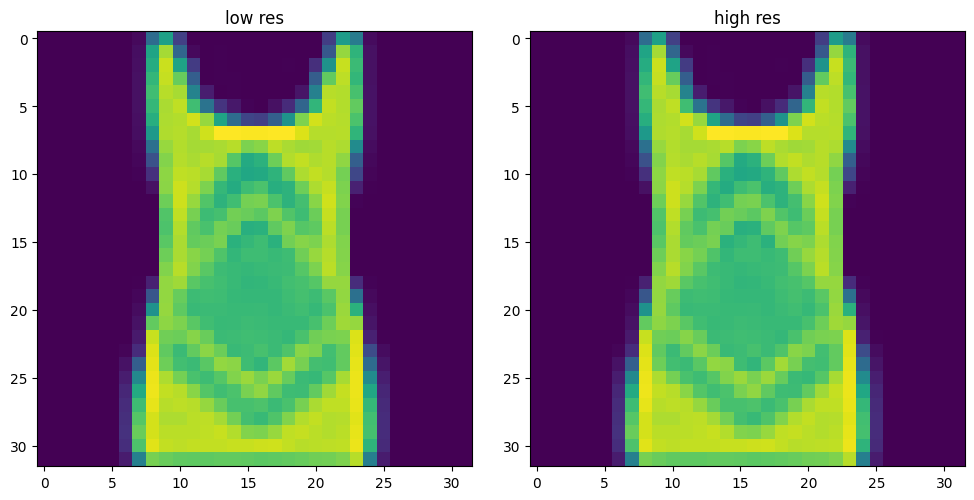

In [4]:
dm.show(torch.randint(0, len(dm.train_dataloader()),(1,)))

In [5]:
dm.dim

[32, 32]

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self, n_features=[1,16, 32, 64, 128]):
        super().__init__()
        self.encoder = nn.ModuleList()
        self.encoder += [ConvLayer(n_features[i], n_features[i+1]) for i in range(0, len(n_features)-1)]
        self.decoder = nn.ModuleList()
        self.decoder += [DeconvLayer(n_features[i],n_features[i-1]) for i in range(len(n_features)-1, 0, -1)]
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
class AutoEncoderX(Regressor):
    def __init__(
        self,
        nnet:AutoEncoder, # super res autoencoder neural net
        optimizer: Callable[...,torch.optim.Optimizer], # optimizer partial
        scheduler: Optional[Callable[...,Any]]=None, # scheduler partial
    ):
        logger.info("SuperResAutoencoderX: init")
        super().__init__(
            nnet=nnet,
            optimizer=optimizer,
            scheduler=scheduler
            )
        self.nnet = nnet
        self.register_module('nnet', self.nnet)

In [8]:
x = torch.randn(8, 1, 32, 32)
ae = AutoEncoder()
y = ae(x)
print(y.shape)


[22:04:21] WARNING - setting conv bias back to False as Batchnorm is used
[22:04:21] WARNING - setting conv bias back to False as Batchnorm is used
[22:04:21] WARNING - setting conv bias back to False as Batchnorm is used
[22:04:21] WARNING - setting conv bias back to False as Batchnorm is used


torch.Size([8, 1, 32, 32])


In [9]:
x = torch.randn(8, 1, 32, 32)
ae = AutoEncoder()
y = ae(x)
print(y.shape)


[22:04:24] WARNING - setting conv bias back to False as Batchnorm is used
[22:04:24] WARNING - setting conv bias back to False as Batchnorm is used
[22:04:24] WARNING - setting conv bias back to False as Batchnorm is used
[22:04:24] WARNING - setting conv bias back to False as Batchnorm is used


torch.Size([8, 1, 32, 32])


[22:04:32] WARNING - setting conv bias back to False as Batchnorm is used
[22:04:32] WARNING - setting conv bias back to False as Batchnorm is used
[22:04:32] WARNING - setting conv bias back to False as Batchnorm is used
[22:04:32] WARNING - setting conv bias back to False as Batchnorm is used
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[22:04:32] INFO - SuperResAutoencoderX: init
[22:04:32] INFO - Regressor: init
/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'nnet' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['nnet'])`.
/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
You 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0003981071705534973
Restoring states from the checkpoint path at /user/s/slegroux/Projects/nimrod/tutorials/.lr_find_d4c18eb9-7297-4441-9ab9-03c9a1922a05.ckpt
Restored all states from the checkpoint at /user/s/slegroux/Projects/nimrod/tutorials/.lr_find_d4c18eb9-7297-4441-9ab9-03c9a1922a05.ckpt


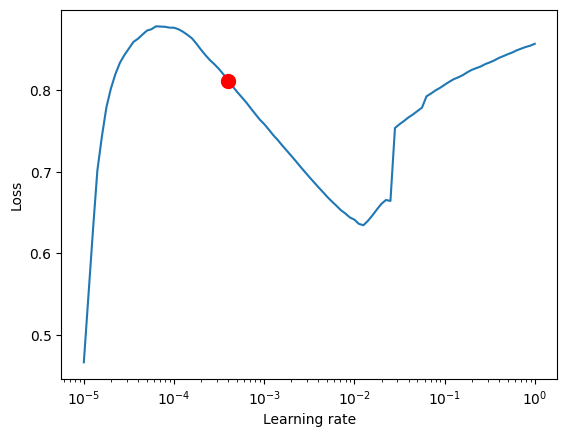

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
[22:04:48] INFO - SuperResAutoencoderX: init
[22:04:48] INFO - Regressor: init


Suggested learning rate: 0.0003981071705534973


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: slegroux. Use `wandb login --relogin` to force relogin


/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /user/s/slegroux/Projects/nimrod/tutorials/checkpoints/Fashion-MNIST-AutoEncoder/AutoEncoderX-bs:512-epochs:5 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[22:04:49] INFO - Regressor: configure_optimizers
[22:04:49] INFO - Optimizer: <class 'torch.optim.adamw.AdamW'>
[22:04:49] INFO - Scheduler: <class 'torch.optim.lr_scheduler.OneCycleLR'>

  | Name         | Type             | Params | Mode 
----------------------------------------------------------
0 | nnet         | AutoEncoder      | 194 K  | train
1 | criterion    | MSELoss          | 0      | train
2 | train_mse    | MeanSquaredError | 0      | train
3 | val_mse      | MeanSquaredError | 0      | train
4 | test_mse     | MeanSquaredError | 0      | train
5 | val_mse_best | MinMetric        | 0      | train
6 | train_loss   | MeanMetric       | 0      | train
7 | val_

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

/user/s/slegroux/miniconda3/envs/nimrod/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/loss         │    0.3841862082481384     │
└───────────────────────────┴───────────────────────────┘

[22:05:01] INFO - Best ckpt path: /user/s/slegroux/Projects/nimrod/tutorials/checkpoints/Fashion-MNIST-AutoEncoder/AutoEncoderX-bs:512-epochs:5/4-0.38-v2.ckpt


epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▆▆▆▆▆▆▆▆▆█████████
lr-AdamW,▁▂▂▂▃▄▄▄▆▆▇▇███████▇▇▇▆▆▅▄▄▄▄▄▃▃▂▂▂▂▂▂▁▁
test/loss,▁
train/loss_epoch,█▂▁▁▁
train/loss_step,██▆▆▅▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇███
val/loss,█▃▁▁▁
val/mse_best,█▄▃▂▁
epoch,5
lr-AdamW,0.0
test/loss,0.38419


In [10]:
# SETUP
PROJECT_NAME = "Fashion-MNIST-AutoEncoder"
N_EPOCHS = 5
do_lr_finder = True
exp_logger = 'wandb'

ae = AutoEncoder()
model = partial(AutoEncoderX, nnet=ae)


tags = [f"bs:{dm.batch_size}", f"epochs:{N_EPOCHS}"]


# LR Finder
if do_lr_finder:
    suggested_lr = lr_finder(model, dm, plot=True)
    print(f"Suggested learning rate: {suggested_lr}")
else:
    suggested_lr = 1e-4

# ONE-CYCLE TRAINING
trained_model, best_ckpt = train_one_cycle(
    model,
    dm,
    n_epochs=N_EPOCHS,
    max_lr=suggested_lr,
    project_name= PROJECT_NAME,
    tags=tags,
    model_summary=False,
    logger_cb=exp_logger
    )

/user/s/slegroux/Projects/nimrod/tutorials/checkpoints/Fashion-MNIST-AutoEncoder/AutoEncoderX-bs:512-epochs:5/4-0.38-v2.ckpt
torch.Size([1, 32, 32])


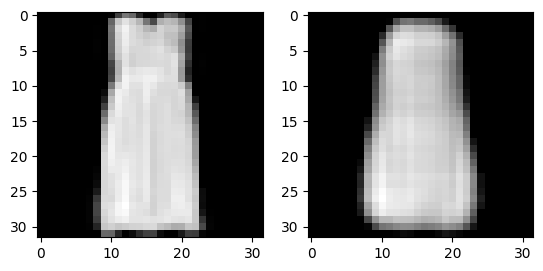

In [26]:
print(best_ckpt)
idx = torch.randint(0, len(dm.test_ds), (1,))
x, y = dm.test_ds[idx]
print(x.shape)
y_hat = trained_model(x.unsqueeze(0))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(y.squeeze(), cmap='gray')
ax[1].imshow(y_hat.squeeze().detach(), cmap='gray')

@cmn17:~/Projects/nimrod/tutorials]1;..rod/tutorials                               
slegroux in 🌐 cmn17 in nimrod/tutorials on  81-u-net [$!?⇡] via 🐍 v3.7.3 
❯ =
@cmn17:~/Projects/nimrod/tutorials]1;..rod/tutorials                               
slegroux in 🌐 cmn17 in nimrod/tutorials on  81-u-net [$!?⇡] via 🐍 v3.7.3 
❯ =